In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
dataSetDir = '/content/drive/My Drive/SWM/SWM/Subtask_A/'

In [ ]:
!pip install transformers
from tqdm import notebook
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaConfig,AdamW, RobertaForSequenceClassification,get_linear_schedule_with_warmup


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, f1_score, precision_score, recall_score
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
file2013 = open(dataSetDir + 'twitter-2013train-A.txt')
file2014 = open(dataSetDir + 'twitter-2014sarcasm-A.txt')
file2015 = open(dataSetDir + 'twitter-2015train-A.txt')
file2016 = open(dataSetDir + 'twitter-2016train-A.txt')
file2013dev = open(dataSetDir + 'twitter-2013dev-A.txt')
file2016dev = open(dataSetDir + 'twitter-2016dev-A.txt')
lines = file2013.readlines()
lines += file2014.readlines()
lines += file2015.readlines()
lines += file2016.readlines()
lines += file2013dev.readlines()
lines += file2016dev.readlines()
print('Number of lines in txt file: {}'.format(len(lines)))

labelsTrain = []
tweetsTrain = []

for line in notebook.tqdm(lines):
    line = line.split()
    labelsTrain.append(line[1])
    line = line[2:]
    tweet = ' '.join(line)
    tweetsTrain.append(tweet)
dfTrain = pd.DataFrame(list(zip(tweetsTrain, labelsTrain)), columns =['tweets', 'labels']) 
dfTrain = dfTrain.sample(frac=1).reset_index(drop=True)
dfTrain = dfTrain[:int(len(dfTrain)*0.9)]
dfTest = dfTrain[int(len(dfTrain)*0.9):]

Number of lines in txt file: 9684


  0%|          | 0/9684 [00:00<?, ?it/s]

In [ ]:
from transformers import BertTokenizer
from transformers import AutoTokenizer
import tensorflow as tf

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace("#","")
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
dfTrain['labels'] = labelencoder.fit_transform(dfTrain['labels'])
dfTrain['tweets'] = dfTrain['tweets'].apply(preprocess)
print(dfTrain.head())
dfTest.head()

                                              tweets  labels
0  1st george clooney 2nd joseph gordon (older an...       1
1  the galaxy s iii will be available in select s...       1
2  sunday\u2019s golf roundup: nick watney flirts...       1
3  looking forward to the judd apatow guest edite...       2
4  girls night out-friday night-november 2nd. fai...       1


,tweets,labels
7843,@Cerullean\u002c thnx for the follow! The Chro...,positive
7844,Hoping to look FIT tomorrow on the Jeremy Kyle...,positive
7845,@Remi_Walker same. I wanna go football really ...,neutral
7846,@courtneyolson12 Courtney!! Do you know if tha...,neutral
7847,@OfficialKat You may have a few extra follower...,positive


In [ ]:
# encoding the training data
train_encoded_inputs = tokenizer(dfTrain['tweets'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=30, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

In [ ]:
train_encoded_inputs

{'input_ids': <tf.Tensor: shape=(8715, 30), dtype=int32, numpy=
array([[  101,  3083,  2577, ...,     0,     0,     0],
       [  101,  1996,  9088, ...,  2006,  6928,   102],
       [  101,  4465,  1032, ...,  2011,  3378,   102],
       ...,
       [  101,  2123,  1032, ...,  2833,  1032,   102],
       [  101,  2065,  2115, ...,  2006, 19675,   102],
       [  101,  1045,  2064, ...,  7490,  2055,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(8715, 30), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
labelsArray = np.array(dfTrain['labels'].values.reshape(len(dfTrain['labels'].values), 1))

dfTrainLabels = encoder.fit_transform(labelsArray)
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, dfTrainLabels))

In [ ]:
# formatting the data as required by bert model
def map_bert(inputs, labels):
  inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}
  
  return inputs, labels

In [ ]:
train_dataset = train_dataset.map(map_bert)

In [ ]:
dataset = train_dataset.shuffle(100000).batch(64)

In [ ]:
DS_LEN = len(dataset)
DS_LEN

137

In [ ]:
# take 80% for train and 20% for validation
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))

In [ ]:
from transformers import TFAutoModel

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# create model architecture
#n_classes = len((train_df.target.unique()))

# Input layers
input_ids = tf.keras.layers.Input(shape=(30,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(30,), dtype=np.int32, name = 'attention_mask')

# bert embeddings
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

# keras layers
#x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# output layer
y = tf.keras.layers.Dense(3, activation='softmax')(x)

# create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                          

In [ ]:
import transformers
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
#optimizer = transformers.AdamWeightDecay(learning_rate=5e-4)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# train the model
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks
)

Epoch 1/50
110/110 [==============================] - 47s 195ms/step - loss: 0.9538 - accuracy: 0.5378 - val_loss: 0.8670 - val_accuracy: 0.6382 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - 19s 170ms/step - loss: 0.8254 - accuracy: 0.6104 - val_loss: 0.7751 - val_accuracy: 0.6693 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - 19s 173ms/step - loss: 0.7862 - accuracy: 0.6339 - val_loss: 0.7086 - val_accuracy: 0.6991 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - 20s 178ms/step - loss: 0.7770 - accuracy: 0.6403 - val_loss: 0.6524 - val_accuracy: 0.7218 - lr: 0.0010
Epoch 5/50
110/110 [==============================] - 20s 178ms/step - loss: 0.7547 - accuracy: 0.6467 - val_loss: 0.6496 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 6/50
110/110 [==============================] - 19s 175ms/step - loss: 0.7385 - accuracy: 0.6602 - val_loss: 0.6250 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 7/50
110/110 [==============================] 

In [ ]:
model.save('/content/drive/My Drive/BertNewModel_1126_lessdata.h5')

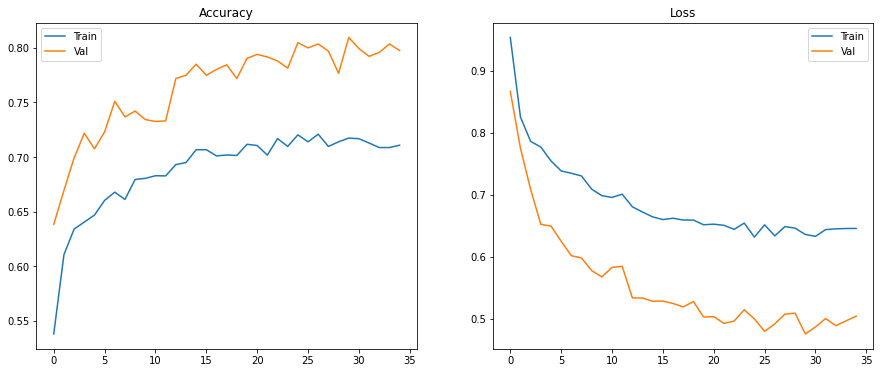

In [ ]:
# plot the performance curve
epochs = history.epoch
plt.figure(figsize=(15, 6))

# Accuracy
plt.subplot(1,2, 1)
plt.plot(epochs, history.history['accuracy'], label="Train")
plt.plot(epochs, history.history['val_accuracy'], label = "Val")
plt.legend()
plt.title("Accuracy")

# loss
plt.subplot(1,2, 2)
plt.plot(epochs, history.history['loss'], label="Train")
plt.plot(epochs, history.history['val_loss'], label = "Val")
plt.legend()
plt.title("Loss")

plt.show()

In [ ]:
# evaluate on val data
model.evaluate(val_ds)

27/27 [==============================] - 4s 133ms/step - loss: 0.5002 - accuracy: 0.7887


[0.5002018809318542, 0.7886567115783691]

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
dfTest['labels'] = labelencoder.fit_transform(dfTest['labels'])
dfTest['tweets'] = dfTest['tweets'].apply(preprocess)
dfTest.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,tweets,labels
7843,thnx for the follow! the chronicles of jan sou...,2
7844,hoping to look fit tomorrow on the jeremy kyle...,2
7845,same. i wanna go football really early tomorro...,1
7846,courtney!! do you know if that emotion scrapbo...,1
7847,you may have a few extra followers from glasgo...,2


In [ ]:
# encoding the test data
test_encoded_inputs = tokenizer(dfTest['tweets'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=30, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encoded_inputs))

In [ ]:
test_ds = test_dataset.batch(64)
test_pred = model.predict(test_ds)
test_pred

14/14 [==============================] - 5s 136ms/step


array([[0.00330238, 0.0095392 , 0.9871585 ],
       [0.0019395 , 0.31469434, 0.6833662 ],
       [0.07684579, 0.383379  , 0.53977513],
       ...,
       [0.00570789, 0.8938599 , 0.10043223],
       [0.05720376, 0.72095084, 0.22184536],
       [0.73496413, 0.21329662, 0.05173925]], dtype=float32)

In [ ]:
test_pred_flatten = np.argmax(test_pred, axis = 1)
print(dfTest['labels'].values.shape)

(872,)


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
confusion_matrix(dfTest['labels'].values, test_pred_flatten)

array([[ 99,  28,  15],
       [ 11, 334,  46],
       [  9,  75, 255]])

In [ ]:
print(accuracy_score(dfTest['labels'].values, test_pred_flatten))

0.7889908256880734


In [ ]:
print(f1_score(dfTest['labels'].values, test_pred_flatten, average='weighted'))
print(accuracy_score(dfTest['labels'].values, test_pred_flatten))
print(precision_score(dfTest['labels'].values, test_pred_flatten, average="weighted"))
print(recall_score(dfTest['labels'].values, test_pred_flatten, average="weighted"))

0.7879848404228914
0.7889908256880734
0.7918998688382443
0.7889908256880734


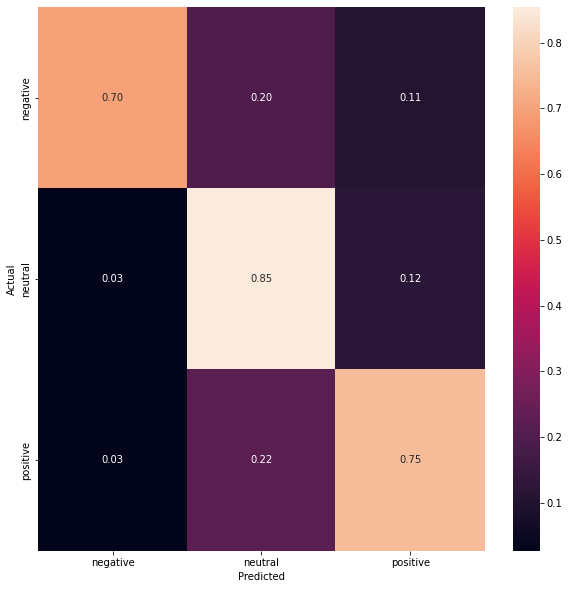

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

target_names = ['negative', 'neutral', 'positive']
cm = confusion_matrix(dfTest['labels'].values, test_pred_flatten)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
y_pred_original = labelencoder.inverse_transform(test_pred_flatten)
print(y_pred_original, test_pred_flatten)


In [ ]:
np.save('/content/drive/My Drive/BERT_label_encoder_classes.npy', labelencoder.classes_)

In [ ]:
from tensorflow import keras
modelLoaded = keras.models.load_model('/content/drive/My Drive/BertNewModel_1126_lessdata.h5' ,custom_objects={'TFBertModel':bert})

In [ ]:
test_pred_loaded_model = modelLoaded.predict(test_ds)
test_pred_loaded_model_flatten = np.argmax(test_pred_loaded_model, axis = 1)

14/14 [==============================] - 2s 129ms/step


In [ ]:
print(f1_score(dfTest['labels'].values, test_pred_loaded_model_flatten, average='weighted'))

0.7879848404228914
